# Imports

In [642]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors

import package_LAB
from importlib import reload
package_LAB = reload(package_LAB)
from package_LAB import SelectPath_RT, Delay_RT, LEAD_LAG_RT, PID_RT, myRound, IMC_TUNING
from package_DBR import FOPDT, SOPDT, FO_RT

# Parameters

In [643]:
TSim = 1500
Ts = 1
N = int(TSim / Ts) + 1

DV0 = 50
MV0 = 50
PV0 = 70


# P(s) = MV -> PV
Kp_p = 0.5438749526909622
T1_p = 184.2423025000344
T2_p = 6.478747375951926e-5
theta_p = 2.9999487500471216

# D(s) = DV -> PV
Kp_d = 0.3939794530691328
T1_d = 225.6571654918062
T2_d = 8.129086232603086
theta_d = 1.1226868296407733

# PID parameters
gamma = 0.2
alpha = 0.1
Kc, Ti, Td = IMC_TUNING(gamma, Kp_p, T1_p, T2_p, theta_p, method='FOPD-PID')

#bounds on MV
MVMin = 0
MVMax = 100
offset_WP = PV0 - Kp_p * MV0

# Simulation vectors

In [644]:
t = []
SP = []
DV = []
PV = []
E = []
MV = []
MVP = []
MVI = []
MVD = []
Man = []
MVMan = []

MVFFDel = []
MVFFLL1 = []
MVFF = []

MVDel_p = []
PV_p1 = []
PV_p2 = []

DVDel_d = []
PV_d1 = []
PV_d2 = []

DV0_vec = []

# Paths

In [645]:
# Closed loop response to a SP change
# ManPath = {0: False, TSim: False}
# MVManPath = {0: MV0, TSim: MV0}
# SPPath = {0: PV0, 850: PV0 + 10, TSim: PV0 + 10}
# DVPath = {0: DV0, 1000: DV0, TSim: DV0}
# FF = False
# ManFF = False

# Response to DV : No FF and controller in manual mode
# ManPath = {0: False, 1: True, TSim: True}
# MVManPath = {0: MV0, TSim: MV0}
# SPPath = {0: PV0, 850: PV0, TSim: PV0}
# DVPath = {0: DV0, 1000: DV0 + 20, TSim: DV0 + 20}
# FF = False
# ManFF = True

# Response to DV : FF and controller in manual mode
# ManPath = {0: False, 1: True, TSim: True}
# MVManPath = {0: MV0, TSim: MV0}
# SPPath = {0: PV0, 850: PV0, TSim: PV0}
# DVPath = {0: DV0, 1000: DV0 + 20, TSim: DV0 + 20}
# FF = True
# ManFF = True

# Response to DV : No FF and controller in automatic mode
# ManPath = {0: False, TSim: True}
# MVManPath = {0: MV0, TSim: MV0}
# SPPath = {0: PV0, 850: PV0, TSim: PV0}
# DVPath = {0: DV0, 1000: DV0 + 20, TSim: DV0 + 20}
# FF = False
# ManFF = False

# Response to DV : FF and controller in automatic mode
ManPath = {0: False, 1100: False, TSim: False}
MVManPath = {0: MV0 + 20, TSim: MV0 + 20}
SPPath = {0: PV0, 850: PV0, TSim: PV0}
DVPath = {0: DV0, 1000: DV0 + 20, TSim: DV0 + 20}
FF = False
ManFF = False

# Simulation

In [646]:
for i in range(0, N):
    t.append(i * Ts)
    
    #create SP
    SelectPath_RT(SPPath, t, SP)
    #create DV
    SelectPath_RT(DVPath, t, DV)
    
    #feedforward
    if (FF):
        Delay_RT(DV - DV0 * np.ones_like(DV), np.max([theta_d - theta_p, 0]), Ts, MVFFDel)
        LEAD_LAG_RT(MVFFDel, - Kp_d / Kp_p, T1_p, T1_d, Ts, MVFFLL1)
        LEAD_LAG_RT(MVFFLL1, 1, T2_p, T2_d, Ts, MVFF)
    else:
        LEAD_LAG_RT(DV, 0, T2_p, T2_d, Ts, MVFF)
        
    #manual mode path
    SelectPath_RT(ManPath, t, Man)
    #manual mode MV
    SelectPath_RT(MVManPath, t, MVMan)
    
    #PID
    PID_RT(SP, PV, Man, MVMan, MVFF, Kc, Ti, Td, alpha, Ts, MVMin, MVMax, MV, MVP, MVI, MVD, E, ManFF, 0)
    
    #P(s) = MV -> PV_p2 (delay + second order)
    Delay_RT(MV, theta_p, Ts, MVDel_p, MV0)
    FO_RT(MVDel_p, Kp_p, T1_p, Ts, PV_p1, 0)
    FO_RT(PV_p1, 1, T2_p, Ts, PV_p2, 0)
    
    #D(s) = DV -> DV_d2 (delay + second order)
    Delay_RT(DV - DV0 * np.ones_like(DV), theta_d, Ts, DVDel_d, 0)
    FO_RT(DVDel_d, Kp_d, T1_d, Ts, PV_d1, 0)
    FO_RT(PV_d1, 1, T2_d, Ts, PV_d2, 0)
    
    #calculate PV = PV_p2 + PV_d2
    PV.append(PV_p2[-1] + PV_d2[-1] + offset_WP)
    
    # print for debug purposes
    # print(str(i) + ': E->' + "%.2f" % E[-1]  + ', MVP->' + "%.2f" % MVP[-1] + ', MVD->' + "%.2f" % MVD[-1] + ', MVI->' + "%.2f" % MVI[-1] + ', MV->' + "%.2f" % MV[-1] + ', PV->' + "%.2f" % PV[-1])
    

# Plot

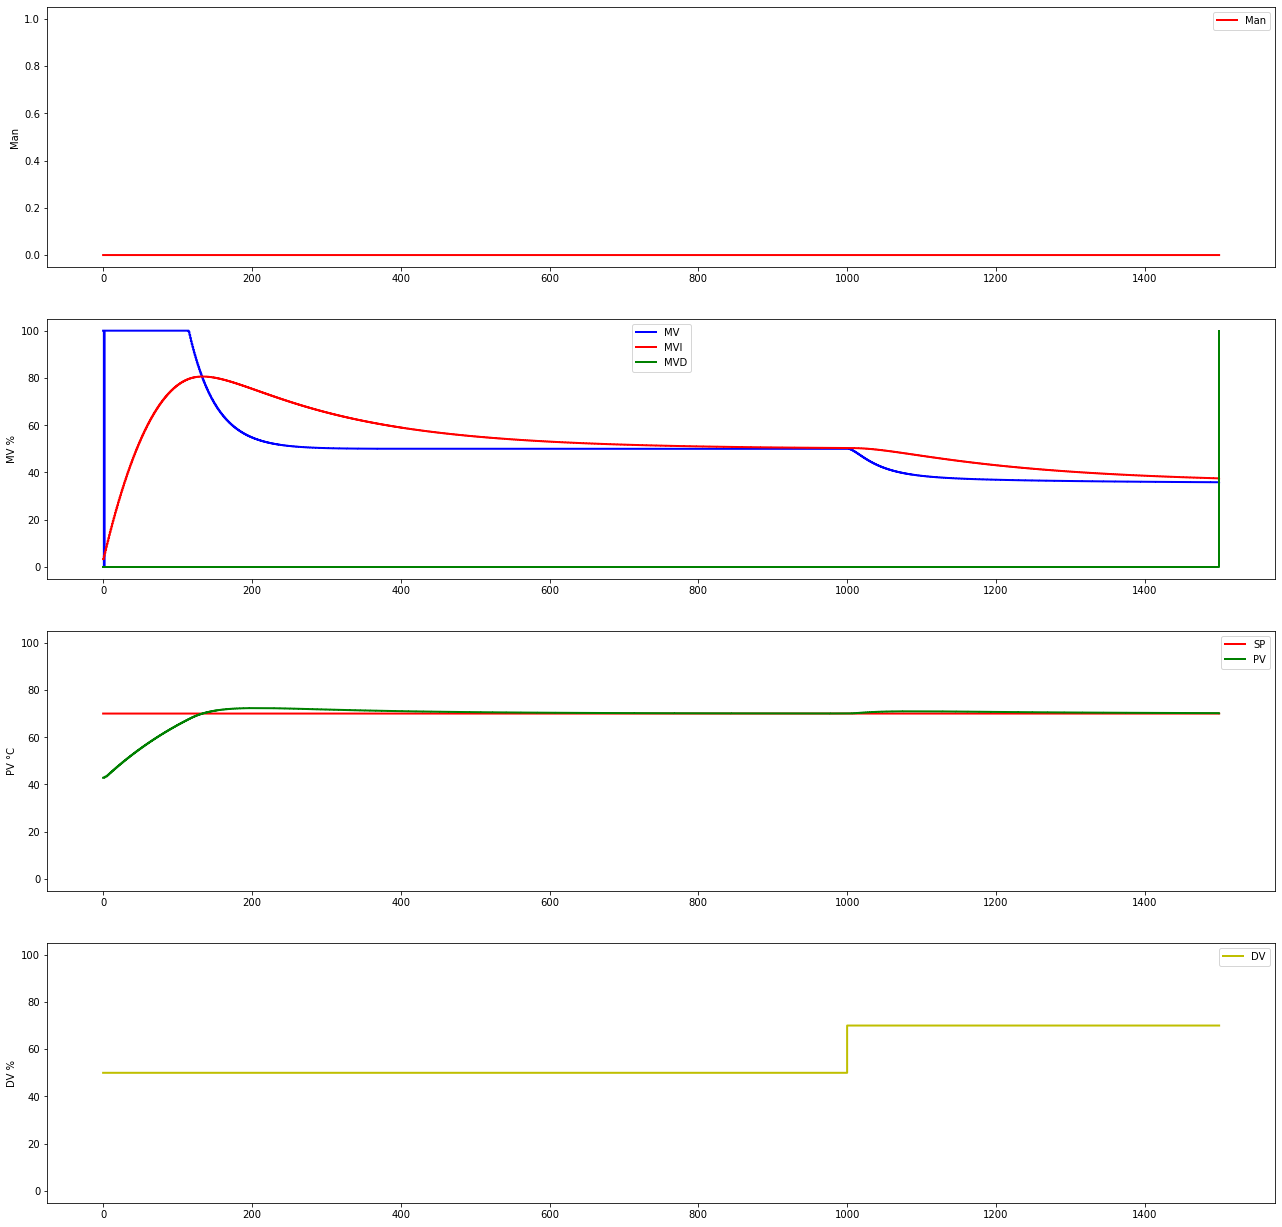

In [647]:
ManPlot = [int(i) for i in Man]
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
fig.set_figheight(22)
fig.set_figwidth(22)

l1, = ax1.step([0, t[-1]], [0, 1], 'r-', linewidth = 2, label = 'Man', where = 'post')
ax1.set_ylabel('Man')
ax1.legend(loc = 'best')
l1.set_data(t, ManPlot)

maxMV = max(MV)
minMV = min(MV)
# l2, = ax2.step([0, t[-1]], [minMV, maxMV], 'b-', linewidth = 2, label = 'MV', where = 'post')
l2, = ax2.step([0, t[-1]], [0, 100], 'b-', linewidth = 2, label = 'MV', where = 'post')
l6, = ax2.step([0, t[-1]], [0, 100], 'r-', linewidth = 2, label = 'MVI', where = 'post')
l7, = ax2.step([0, t[-1]], [0, 100], 'g-', linewidth = 2, label = 'MVD', where = 'post')
ax2.set_ylabel('MV %')
ax2.legend(loc = 'best')
# l7.set_data(t, MVD)
l6.set_data(t, MVI)
l2.set_data(t, MV)

maxSP = max(SP)
minSP = min(SP)
maxPV = max(PV)
minPV = min(PV)
# l3, = ax3.step([0, t[-1]], [min(minSP, minPV), max(maxSP, maxPV)], 'r-', linewidth = 2, label = 'SP', where = 'post')
# l4, = ax3.step([0, t[-1]], [min(minSP, minPV), max(maxSP, maxPV)], 'g-', linewidth = 2, label = 'PV', where = 'post')
l3, = ax3.step([0, t[-1]], [0, 100], 'r-', linewidth = 2, label = 'SP', where = 'post')
l4, = ax3.step([0, t[-1]], [0, 100], 'g-', linewidth = 2, label = 'PV', where = 'post')
ax3.set_ylabel('PV °C')
ax3.legend(loc = 'best')
l3.set_data(t, SP)
l4.set_data(t, PV)

maxDV = max(DV)
minDV = min(DV)
#l5, = ax4.step([0, t[-1]], [minDV, maxDV], 'y-', linewidth = 2, label = 'DV', where = 'post')
l5, = ax4.step([0, t[-1]], [0, 100], 'y-', linewidth = 2, label = 'DV', where = 'post')
ax4.set_ylabel('DV %')
ax4.legend(loc = 'best')
l5.set_data(t, DV)

# plt.savefig('Plots/wind up' + '.png',transparent=True)
# plt.savefig('Plots/wind up' + '.pdf',transparent=True)